# Lab 3 - Neural and neurosymbolic search

Note: I am running this on my personal laptop, which has an RTX3050 8GBs (I know, I know, it's an old laptop). In practice, I can only do 0.5B models. I also tried a larger model on the server, as detailed below. Eventually I want to add a section on neurosymbolic search, using the LLM as a proposal function. 

## Imports 

We are using the following libraries:
- Huggingface's Transformers
- Unsloth: integrates with TRL and Transformers, can fine-tune LLMs using a variety of methods much faster than other libraries.
- vllm: Starts a server to do LLM stuff with, makes inference faster.
- trl: Reinforcement Learning fine-tuning

In [1]:
import re
import itertools
import math
import time
import random
from collections import Counter
from pprint import pprint
import json

import numpy as np
import pandas as pd
from numpy.random import choice, randint
from IPython.display import HTML, display, clear_output
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Utilities for plotting
from symbolic_utilities import progress, compute_global_limits_smc, plot_mh_trace_upto, plot_state_2d
# MHMC sampler
from symbolic_utilities import propose_tree, get_coordinates, \
    mh_sampler, smc_sampler, define_bs_DSL, define_lt_DSL, enumerate_full_sentences

from neural_utilities import extract_xml_answer, extract_xml_reasoning, produce_tasks, get_data

from neural_utilities import print_func, lt_correctness_reward_func, \
    xmlcount_reward_func, soft_format_reward_func, strict_format_reward_func, cfg_reward_func, lt_correctness_reward_func, \
    direct_cfg_reward_func, direct_lt_correctness_reward_func, direct_conciseness_reward_func

from symbolic_utilities import \
    ltgrammar, lt_nonterminals, lt_terminals, lt_eval_dict, \
    bsgrammar, bs_nonterminals, bs_terminals, bs_eval_dict

# NOTE: PatchFastRL needs to run **before** the imports below
from unsloth import FastLanguageModel, is_bfloat16_supported, PatchFastRL
PatchFastRL("GRPO", FastLanguageModel)

import torch, gc
from torch import tensor
from datasets import load_dataset, Dataset, DatasetDict
from transformers import EarlyStoppingCallback, TextStreamer, TrainingArguments
from peft import AutoPeftModelForCausalLM
from trl import SFTTrainer, GRPOConfig, GRPOTrainer
from unsloth.chat_templates import get_chat_template
from vllm import SamplingParams

from dotenv import load_dotenv, find_dotenv
import os
from openai import OpenAI

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 03-14 09:08:39 __init__.py:190] Automatically detected platform cuda.


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3050 Ti Laptop GPU


##  Using supervised and RL finetuning to improve inductive synthesis

Some random things we're gonna need below:

In [15]:
def check_accuracy(x, indices, functions):
    function = functions[indices]
    accuracy = 0
    for inp, out in x['examples']:
        if out == function(inp):
            accuracy += 1/len(x['examples'])
    return {'accuracy': accuracy}

In [3]:
max_seq_length = 1024 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower

In [4]:
lt_system_prompt = ""

Let's start by defining some data that we'll use to train the model:

In [5]:
# get all sentences up to depth 5
sentences_pool = []
for i, sent in enumerate(enumerate_full_sentences('T', ltgrammar, max_depth=6)):
    sentences_pool.append(sent)
    if i==500000:
        break

In [6]:
data = get_data(
    ltgrammar, 
    lt_system_prompt, 
    eval_dict=lt_eval_dict, 
    n_tasks=100000, 
    sentences_pool=sentences_pool
)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Add the "completion" column to data which contains the string that the model is supposed to produce for the corresponding examples, containing a format that makes the model happy (we can later use the tokenizer to turn it into a properly formatted input for the model):

In [7]:
data = data.map(lambda x: {
    'completion': [{'content': x['sentence'], 'role': 'assistant'}], 
})

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [8]:
# 90% train, 10% test + validation
train_testvalid = data.train_test_split(train_size=2**16, test_size=2* 2**7)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
data = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [9]:
data

DatasetDict({
    train: Dataset({
        features: ['sentence', 'examples', 'task', 'prompt', 'completion'],
        num_rows: 65536
    })
    test: Dataset({
        features: ['sentence', 'examples', 'task', 'prompt', 'completion'],
        num_rows: 128
    })
    valid: Dataset({
        features: ['sentence', 'examples', 'task', 'prompt', 'completion'],
        num_rows: 128
    })
})

Later we can get an impressionistic idea of how the model is behaving by getting a datapoint:

In [10]:
d = data['test'][1]['prompt']

In [11]:
d

[{'content': '', 'role': 'system'},
 {'content': '-[9, 0, 6, 0, 5] -> [13, 4, 10, 4, 9]\n-[7, 0, 6, 6] -> [11, 4, 10, 10]\n-[5, 3, 2, 4, 6] -> [9, 7, 6, 8, 10]',
  'role': 'user'}]

Some terminal are more represented than others - this is just due to the way the grammar is structured. You can imagine it as defining a distribution over tasks in our environment:

In [12]:
c = Counter()
for s in data['train']['sentence']:
   c.update({k:s.count(k) for k in lt_terminals})

c

Counter({'(': 619144,
         ')': 619144,
         ',': 296764,
         'even': 164059,
         'gt': 140866,
         'and_': 120459,
         'or_': 118954,
         'filter_': 65512,
         'compose': 57351,
         'map_': 40899,
         'plus': 40887,
         '1': 36650,
         '4': 36519,
         '2': 36448,
         '3': 36245,
         '5': 35907,
         'not_': 34200,
         'reverse': 8328,
         'sort': 8144,
         'minus': 7,
         'times': 5,
         'truncate': 4})

Let's check that the test data is not out of distribution!

In [13]:
c = Counter()
for s in data['test']['sentence']:
   c.update({k:s.count(k) for k in lt_terminals})

c

Counter({'(': 1240,
         ')': 1240,
         ',': 583,
         'even': 310,
         'gt': 284,
         'or_': 234,
         'and_': 232,
         'filter_': 128,
         'compose': 117,
         'map_': 90,
         'plus': 90,
         '1': 84,
         '4': 78,
         '2': 77,
         '5': 70,
         '3': 65,
         'not_': 65,
         'sort': 15,
         'reverse': 12,
         'truncate': 0,
         'minus': 0,
         'times': 0})

This is what our data looks like ('sentence' is the expression that produced the datapoint, which is not necessarily the best one!):

In [14]:
data['test'].to_pandas().head()

,sentence,examples,task,prompt,completion
0,"compose(map_(plus(5)),filter_(and_(or_(gt(2),o...","[[[7, 7, 3, 0], [12, 12, 8, 5]], [[6, 7], [11,...","-[7, 7, 3, 0] -> [12, 12, 8, 5]\n-[6, 7] -> [1...","[{'content': '', 'role': 'system'}, {'content'...","[{'content': 'compose(map_(plus(5)),filter_(an..."
1,"compose(map_(plus(4)),filter_(or_(or_(gt(2),ev...","[[[9, 0, 6, 0, 5], [13, 4, 10, 4, 9]], [[7, 0,...","-[9, 0, 6, 0, 5] -> [13, 4, 10, 4, 9]\n-[7, 0,...","[{'content': '', 'role': 'system'}, {'content'...","[{'content': 'compose(map_(plus(4)),filter_(or..."
2,"compose(map_(plus(1)),filter_(or_(even,or_(eve...","[[[1, 5, 2, 4, 8], [2, 6, 3, 5, 9]], [[7, 3, 4...","-[1, 5, 2, 4, 8] -> [2, 6, 3, 5, 9]\n-[7, 3, 4...","[{'content': '', 'role': 'system'}, {'content'...","[{'content': 'compose(map_(plus(1)),filter_(or..."
3,"compose(map_(plus(1)),filter_(and_(and_(gt(5),...","[[[8, 6], [9, 7]], [[3, 5, 0], []], [[8, 5], [...","-[8, 6] -> [9, 7]\n-[3, 5, 0] -> []\n-[8, 5] -...","[{'content': '', 'role': 'system'}, {'content'...","[{'content': 'compose(map_(plus(1)),filter_(an..."
4,"compose(map_(plus(1)),filter_(and_(or_(even,gt...","[[[9, 2, 5, 4], [10, 6]], [[0, 3, 2, 5], [4, 6...","-[9, 2, 5, 4] -> [10, 6]\n-[0, 3, 2, 5] -> [4,...","[{'content': '', 'role': 'system'}, {'content'...","[{'content': 'compose(map_(plus(1)),filter_(an..."


** Run only until here later for GRPO **

Now we can get a base model. I have chosen Qwen2.5-0.5B-Instruct, because I have an old laptop (if any billionare is reading this, by all means feel free to donate a fancy one): 

In [16]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-0.5B-Instruct",
    max_seq_length=max_seq_length,
    # False for LoRA 16bit
    load_in_4bit=True, 
    # Enable vLLM fast inference
    fast_inference=True, 
    max_lora_rank=lora_rank,
    # Reduce if out of memory
    gpu_memory_utilization=0.5, 
)

# get the model with the lora adapters on top
model = FastLanguageModel.get_peft_model(
    model,
    # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    r=lora_rank, 
    # Which parts of the model are we gonna train?
    target_modules=[
        "q_proj", 
        "k_proj", 
        "v_proj", 
        "o_proj",
        "gate_proj", 
        "up_proj", 
        "down_proj",
    ], 
    lora_alpha=lora_rank,
    # Enable long context finetuning
    use_gradient_checkpointing = "unsloth", 
    random_state=3407,
)

==((====))==  Unsloth 2025.2.12: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU. Max memory: 4.0 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-0.5b-instruct-unsloth-bnb-4bit with actual GPU utilization = 40.19%
Unsloth: Your GPU has CUDA compute capability 8.6 with VRAM = 4.0 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 1024. Num Sequences = 128.
Unsloth: vLLM's KV Cache can use up to 1.08 GB. Also swap space = 1 GB.
INFO 03-12 19:03:08 config.py:542] This model supports multiple tasks: {'generate', 'score', 'embed', 'reward', 'classify'}. Defaulting to 'generate'.
Unsloth: vLLM Bitsandbytes con

[W312 19:03:12.120379259 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


INFO 03-12 19:03:12 loader.py:1102] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 03-12 19:03:13 weight_utils.py:252] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-12 19:03:15 model_runner.py:1115] Loading model weights took 0.5090 GB
INFO 03-12 19:03:15 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 03-12 19:03:19 worker.py:267] Memory profiling takes 3.49 seconds
INFO 03-12 19:03:19 worker.py:267] the current vLLM instance can use total_gpu_memory (4.00GiB) x gpu_memory_utilization (0.40) = 1.61GiB
INFO 03-12 19:03:19 worker.py:267] model weights take 0.51GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 0.70GiB; the rest of the memory reserved for KV Cache is 0.37GiB.
INFO 03-12 19:03:20 executor_base.py:110] # CUDA blocks: 2034, # CPU blocks: 5461
INFO 03-12 19:03:20 executor_base.py:115] Maximum concurrency for 1024 tokens per request: 31.78x
INFO 03-12 19:03:20 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occu

Capturing CUDA graph shapes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:22<00:00,  1.19s/it]

INFO 03-12 19:03:43 model_runner.py:1562] Graph capturing finished in 23 secs, took 0.30 GiB
INFO 03-12 19:03:43 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 27.42 seconds



Unsloth 2025.2.12 patched 24 layers with 24 QKV layers, 24 O layers and 24 MLP layers.


Now that we have a model we can apply the model's chat template to the datapoint we are using as a vibe check:

In [15]:
inputs = tokenizer.apply_chat_template(
    d,  
    # add generation from because we want to 
    # generate a response from the model
    add_generation_prompt=True,
    tokenize=True,
    return_tensors="pt",
    # return_dict=True,
).to('cuda')

In [16]:
inputs

tensor([[151644,   8948,    198, 151645,    198, 151644,    872,    198,  40995,
             18,     11,    220,     22,     11,    220,     15,     11,    220,
             16,     60,   1464,   4167,  40995,     24,     11,    220,     22,
             11,    220,     16,     60,   1464,   4167,  40995,     22,     11,
            220,     24,     11,    220,     23,     60,   1464,    508,     23,
             60, 151645,    198, 151644,  77091,    198]], device='cuda:0')

Let's start by getting a sense of what the base model produced for our task:

In [48]:
FastLanguageModel.for_inference(model)
text_streamer = TextStreamer(tokenizer)
_ = model.generate(
    inputs, 
    streamer=text_streamer, 
    max_new_tokens=512,
)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<|im_start|>system
<|im_end|>
<|im_start|>user
-[2, 0, 5, 1, 6] -> [5]
-[3, 6, 4, 8, 9] -> [9, 3]
-[1, 3, 5, 0] -> [5, 3]<|im_end|>
<|im_start|>assistant
To transform the given arrays into the desired output, we can use a simple mapping process. Here's how we can do it:

1. For the first array `[2, 0, 5, 1, 6]`, we map it to `[5]`.
2. For the second array `[3, 6, 4, 8, 9]`, we map it to `[9, 3]`.
3. For the third array `[1, 3, 5, 0]`, we map it to `[5, 3]`.

Here's the final result:

```swift
let inputArray = [2, 0, 5, 1, 6]
let mappedArray = inputArray.map { $0.map { $0 == 0 ? 5 : $0 } }

print(mappedArray) // Output: [5, 9, 3, 5, 3]
```

This code uses the `map` function to apply the `== 0` condition to each element in the input array, and then maps the result to the desired output format.<|im_end|>


This looks nothing like what we need, of course: we haven't even told the model what shape we want for our programs.

In [49]:
%%capture
FastLanguageModel.for_training(model)

So instead of just generating the model directly, we can fine-tune the model to give the kind of response we want. 

Let's do supervised fine tuning on the model:

In [17]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        learning_rate=3e-5,
        lr_scheduler_type="linear",
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,
        # validation accuracy was going up again when training for too long!
        num_train_epochs=0.4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.05,
        warmup_steps=10,
        output_dir="lt_SFT_noreasoning",
        seed=0,
        save_steps=100,
        # feedback from evaluation set
        # from: https://github.com/unslothai/unsloth/wiki#evaluation-loop---also-oom-or-crashing
        fp16_full_eval=True,
        per_device_eval_batch_size=2,
        eval_accumulation_steps=4,
        eval_strategy="steps",
        eval_steps=10,
    ),
)

Map:   0%|          | 0/65536 [00:00<?, ? examples/s]

Converting train dataset to ChatML (num_proc=2):   0%|          | 0/65536 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/65536 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/65536 [00:00<?, ? examples/s]

Packing train dataset (num_proc=2):   0%|          | 0/65536 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Converting eval dataset to ChatML (num_proc=2):   0%|          | 0/128 [00:00<?, ? examples/s]

Applying chat template to eval dataset (num_proc=2):   0%|          | 0/128 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=2):   0%|          | 0/128 [00:00<?, ? examples/s]

Packing eval dataset (num_proc=2):   0%|          | 0/128 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


And let's train the model:

In [ ]:
trainer.train()

At this point we have the model and the adapter which contains the lora weights.

In [31]:
trainer.save_model('finetuned_lt')

And we can get the model with the lora adaptor we just trained (it might make sense to restart the kernel before going foward and not load any previous model to make sure the GPU is empty):

In [16]:
%%capture
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "finetuned_lt",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    # Enable vLLM fast inference
    fast_inference = True, 
)

INFO 03-13 17:33:48 config.py:542] This model supports multiple tasks: {'embed', 'classify', 'reward', 'score', 'generate'}. Defaulting to 'generate'.
INFO 03-13 17:33:49 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='unsloth/qwen2.5-0.5b-instruct-unsloth-bnb-4bit', speculative_config=None, tokenizer='unsloth/qwen2.5-0.5b-instruct-unsloth-bnb-4bit', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=1024, download_dir=None, load_format=LoadFormat.BITSANDBYTES, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=bitsandbytes, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda:0, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), 

[W313 17:33:50.736917400 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


INFO 03-13 17:33:50 loader.py:1102] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 03-13 17:33:51 weight_utils.py:252] Using model weights format ['*.safetensors']
INFO 03-13 17:33:53 model_runner.py:1115] Loading model weights took 0.5090 GB
INFO 03-13 17:33:53 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 03-13 17:33:56 worker.py:267] Memory profiling takes 2.87 seconds
INFO 03-13 17:33:56 worker.py:267] the current vLLM instance can use total_gpu_memory (4.00GiB) x gpu_memory_utilization (0.40) = 1.61GiB
INFO 03-13 17:33:56 worker.py:267] model weights take 0.51GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 0.70GiB; the rest of the memory reserved for KV Cache is 0.37GiB.
INFO 03-13 17:33:56 executor_base.py:110] # CUDA blocks: 2034, # CPU blocks: 5461
INFO 03-13 17:33:56 executor_base.py:115] Maximum concurrency for 1024 tokens per request: 31.78x
INFO 03-13 17:33:57 model_runner.py:1434] Capturing cudagraphs for decoding

Unsloth 2025.2.12 patched 24 layers with 24 QKV layers, 24 O layers and 24 MLP layers.


In [17]:
# strangely, this is not a default
tokenizer.padding_side = 'left'

In [18]:
inputs = tokenizer.apply_chat_template(
    data['test']['prompt'],  
    # add generation prompt because we want to 
    # generate a response from the model
    add_generation_prompt=True,
    tokenize=True,
    # return_tensors="pt",
    padding=True,
    return_dict=True,
)

In [19]:
print(tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True))

system

user
-[7, 7, 3, 0] -> [12, 12, 8, 5]
-[6, 7] -> [11, 12]
-[8, 6] -> [13, 11]
assistant



After the supervised finetuning, we should get answers that look a lot closer to what we want. Let's run the model on the test set to confirm this.

In [22]:
%%capture
FastLanguageModel.for_inference(model)

(`tokenizer.batch_decode` does not work: when the input contains padding tokens the generation is nonsense, even when applying an `attention_mask` and specifying `pad_token_id`. Not sure what is going on here, but after some debugging and no solution I decided to just avoid batching and generate in a loop. Alas, time is a finite resource)

In [156]:
answer = []
for inp in inputs['input_ids']:
    text_upto_padding = inp[inp.index(151644)+1:]
    sft_test_generation = model.generate(
        tensor([text_upto_padding], dtype=torch.int64).to('cuda'),
        # attention_mask=inputs['attention_mask'][10][None],
        pad_token_id=tokenizer.pad_token_id,
        max_new_tokens=128,
    )
    answer.append(tokenizer.decode(sft_test_generation[0][len(text_upto_padding):],skip_special_tokens=True))

In [158]:
answer[0]

'compose(map_(plus(1)),filter_(or_(and_(gt(1),gt(1)),and_(gt(1),gt(1)))))'

And let's see how accurate these answers were:

In [175]:
functions = [eval(a, lt_eval_dict) for a in answer]
data['test'] = data['test'].map(check_accuracy, fn_kwargs={'functions':functions}, with_indices=True)

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Let's look at the average number of correct predictions across the three examples across the dataset. Not good, not terrible:

In [180]:
np.mean(data['test']['accuracy'])

0.16145833333333331

In [18]:
%%capture
FastLanguageModel.for_training(model)

We can do better. Let's try the RL fine-tuning on the distilled model:

In [20]:
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        print_func,
        direct_cfg_reward_func,
        direct_lt_correctness_reward_func,
        direct_conciseness_reward_func
    ],
    args=GRPOConfig(
        # use vLLM for fast inference! (it raises an error)
        # use_vllm = True, 
        learning_rate = 5e-6,
        adam_beta1 = 0.9,
        adam_beta2 = 0.99,
        weight_decay = 0.1,
        warmup_ratio = 0.1,
        lr_scheduler_type = "cosine",
        optim = "adamw_8bit",
        logging_steps = 1,
        bf16 = is_bfloat16_supported(),
        fp16 = not is_bfloat16_supported(),
        per_device_train_batch_size = 1,
        # Increase to 4 for smoother training
        gradient_accumulation_steps = 1, 
        # Decrease if out of memory
        num_generations = 8, 
        max_prompt_length = 256,
        max_completion_length = 64,
        # Set to 1 for a full training run
        num_train_epochs = 1, 
        max_steps = 10000,
        save_steps = 500,
        max_grad_norm = 0.1,
        # Can use Weights & Biases
        report_to = "none", 
        output_dir = "outputs",
        resume_from_checkpoint=True
    ),
    train_dataset=data['train'],
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Unsloth: We know expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 8


In [21]:
trainer.train(
    # comment out if you don't need it!
    resume_from_checkpoint=True
)

/home/fausto/mambaforge/envs/arccourse/lib/python3.11/site-packages/transformers/trainer.py:3423: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(check

------------------------------ 
**Question**
-[9, 6] -> [10, 7]
-[8, 3, 0, 5] -> [9, 4, 6]
-[2, 2] -> [3, 3] 

**Response**
compose(map_(plus(1)),filter_(gt(1))) 

**Extracted**
compose(map_(plus(1)),filter_(gt(1)))


Prediction:  compose(map_(plus(1)),filter_(gt(1)))
[9, 6] --> [10, 7] vs [10, 7]
Prediction:  compose(map_(plus(1)),filter_(gt(1)))
[8, 3, 0, 5] --> [9, 4, 6] vs [9, 4, 6]
Prediction:  compose(map_(plus(1)),filter_(gt(1)))
[2, 2] --> [3, 3] vs [3, 3]
Prediction:  compose(map_(plus(1)),filter_(gt(2)))
[9, 6] --> [10, 7] vs [10, 7]
Prediction:  compose(map_(plus(1)),filter_(gt(2)))
[8, 3, 0, 5] --> [9, 4, 6] vs [9, 4, 6]
Prediction:  compose(map_(plus(1)),filter_(gt(2)))
[2, 2] --> [3, 3] vs [3, 3]
Prediction:  compose(map_(plus(1)),filter_(gt(2)))
[9, 6] --> [10, 7] vs [10, 7]
Prediction:  compose(map_(plus(1)),filter_(gt(2)))
[8, 3, 0, 5] --> [9, 4, 6] vs [9, 4, 6]
Prediction:  compose(map_(plus(1)),filter_(gt(2)))
[2, 2] --> [3, 3] vs [3, 3]
Prediction:  compose(map_(plu

Step,Training Loss,reward,reward_std,completion_length,kl,rewards / print_func,rewards / direct_cfg_reward_func,rewards / direct_lt_correctness_reward_func,rewards / direct_conciseness_reward_func
7001,0.175600,4.190734,0.000000,14.000000,4.389789,0.000000,0.500000,3.000000,0.690734
7002,0.249200,1.875000,0.231455,14.000000,6.229631,0.000000,0.500000,1.375000,0.000000
7003,0.211700,0.729167,0.294628,13.750000,5.292799,0.000000,0.437500,0.291667,0.000000
7004,0.384400,3.143051,1.939933,20.125000,9.610527,0.000000,0.375000,2.250000,0.518051
7005,0.583800,2.375000,1.465882,20.125000,14.594269,0.000000,0.375000,2.000000,0.000000
7006,0.242600,2.000000,0.000000,10.000000,6.064757,0.000000,0.500000,1.500000,0.000000
7007,0.241200,4.233447,0.000000,10.000000,6.030917,0.000000,0.500000,3.000000,0.733447
7008,0.185200,4.190734,0.000000,14.000000,4.629368,0.000000,0.500000,3.000000,0.690734
7009,0.240700,2.145833,0.258775,10.000000,6.016520,0.000000,0.500000,1.645833,0.000000
7010,0.182200,4.190734,0.000000,14.000000,4.555621,0.000000,0.500000,3.000000,0.690734


------------------------------ 
**Question**
-[5, 2, 0, 2, 0] -> []
-[4, 0] -> [6]
-[0, 8, 9, 1] -> [10] 

**Response**
compose(map_(plus(2)),filter_(gt(5))) 

**Extracted**
compose(map_(plus(2)),filter_(gt(5)))


Prediction:  compose(map_(plus(2)),filter_(gt(5)))
[5, 2, 0, 2, 0] --> [7] vs []
Prediction:  compose(map_(plus(2)),filter_(gt(5)))
[4, 0] --> [6] vs [6]
Prediction:  compose(map_(plus(2)),filter_(gt(5)))
[0, 8, 9, 1] --> [10, 11] vs [10]
Prediction:  compose(map_(plus(2)),filter_(gt(5)))
[5, 2, 0, 2, 0] --> [7] vs []
Prediction:  compose(map_(plus(2)),filter_(gt(5)))
[4, 0] --> [6] vs [6]
Prediction:  compose(map_(plus(2)),filter_(gt(5)))
[0, 8, 9, 1] --> [10, 11] vs [10]
Prediction:  compose(map_(gt(4)),filter_(gt(2)))
[5, 2, 0, 2, 0] --> [] vs []
Prediction:  compose(map_(gt(4)),filter_(gt(2)))
[4, 0] --> [] vs [6]
Prediction:  compose(map_(gt(4)),filter_(gt(2)))
[0, 8, 9, 1] --> [] vs [10]
Prediction:  compose(map_(plus(2)),filter_(gt(5)))
[5, 2, 0, 2, 0] --> [7] vs []
Pr

KeyboardInterrupt: 

In [22]:
df_history = pd.DataFrame(trainer.state.log_history)

We are getting improving, though very slow!

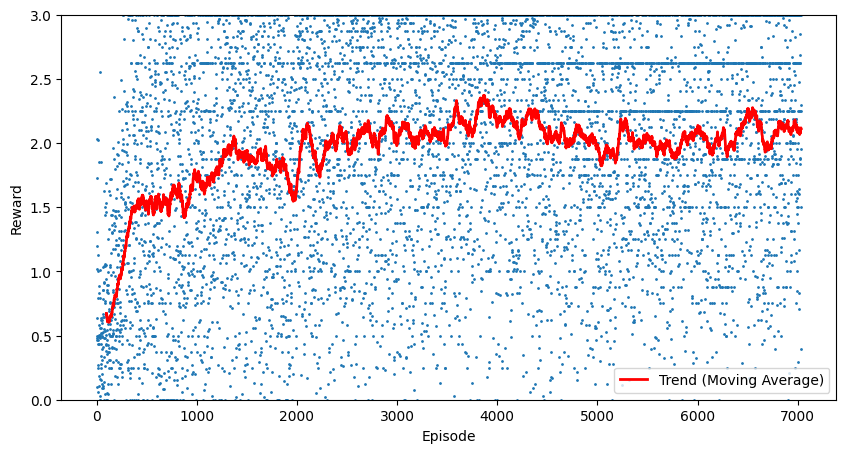

In [24]:
smoothed_rewards = df_history['rewards/direct_lt_correctness_reward_func'].rolling(window=100).mean()

# Plotting the raw reward and the trend (smoothed reward)
plt.figure(figsize=(10, 5))
plt.plot(df_history.index, smoothed_rewards, label="Trend (Moving Average)", color="red", linewidth=2)
plt.scatter(df_history.index, df_history['rewards/direct_lt_correctness_reward_func'], s=1)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.ylim(0,3)
plt.legend()
plt.show()

And now let's check accuracy on the test set again:

In [27]:
%%capture
model.for_inference()

In [28]:
answer = []
for inp in inputs['input_ids']:
    text_upto_padding = inp[inp.index(151644)+1:]
    sft_test_generation = model.generate(
        tensor([text_upto_padding], dtype=torch.int64).to('cuda'),
        # attention_mask=inputs['attention_mask'][10][None],
        pad_token_id=tokenizer.pad_token_id,
        max_new_tokens=128,
    )
    answer.append(tokenizer.decode(sft_test_generation[0][len(text_upto_padding):],skip_special_tokens=True))

In [29]:
answer[0]

'compose(map_(plus(5)),filter_(gt(4)))'

And let's see how accurate these answers were:

In [30]:
functions = [eval(a, lt_eval_dict) for a in answer]
data['test'] = data['test'].map(check_accuracy, fn_kwargs={'functions':functions}, with_indices=True)

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Let's look at the average number of correct predictions across the three examples across the dataset. Not good, not terrible:

In [31]:
np.mean(data['test']['accuracy'])

0.7109375

Much, much better!

But we can do _even better_, by exploiting the fact that we can check which productions fit out dataset. Let's produce a bunch of options and pick the one that produces the most accurate outputs given the example inputs. First, get the test tokens to generate from

In [95]:
inputs = tokenizer.apply_chat_template(
    data['test']['prompt'],  
    # add generation prompt because we want to 
    # generate a response from the model
    add_generation_prompt=True,
    tokenize=True,
    # return_tensors="pt",
    padding=True,
    return_dict=True,
)

Then, generate 32 attempts for each answer (note: there are many other ways to do this! Unfortunately qwen doesn't seem to support beams for now):

In [174]:
answer = []
for i, inp in enumerate(inputs['input_ids']):
    text_upto_padding = inp[inp.index(151644)+1:]
    x = model.generate(
        tensor([text_upto_padding], dtype=torch.int64).to('cuda'),
        pad_token_id=tokenizer.pad_token_id,
        max_new_tokens=64,
        num_return_sequences=32,
        do_sample=True
    )
    answer.append(tokenizer.batch_decode(
        x,
        skip_special_tokens=True
    ))
    print(i, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 

In [175]:
# cut the prompt tokens
fixed_answer = []
for a,inp in zip(answer,inputs['input_ids']):
    sub = []
    for x in a:
        sub.append(x[x.index('assistant')+10:])
    fixed_answer.append(sub)

In [176]:
def check_accuracy_samples(x, indices, functions):    
    # initialize with 0 in case no solution was found
    utilities = [0]
    fs = functions[indices]
    for f in fs:
        if is_in_lt_CFG(f):
            try:
                f = eval(f, lt_eval_dict)
                # if predictions are perfect, try to minimize length of formula
                utilities.append(np.mean([f(inp)==out for inp, out in x['examples']]))
            except Exception:
                pass
    return {'accuracy': max(utilities)}

In [177]:
data['test'] = data['test'].map(check_accuracy_samples, fn_kwargs={'functions':fixed_answer}, with_indices=True)

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

As it turns out, it doesn't actually help much in this instance:

In [178]:
np.mean(data['test']['accuracy'])

0.7395833333333333

but it does in other cases, especially if you produce a lot of sentences!

## With a larger model (on the server)

I ran the code above with SFT and then GRPO on but starting with Qwen2.5-14B-Instruct-bnb-4bit (the code is in the SLURM folder!), with the only difference that in the GRPO I did not add a penalty for formula length and I trained on a smaller dataset (you can see the parameters in the `SLURM` folder files.)

Here is the first and last steps of GRPO, showing the first four (out of 32) generations in the group and their corresponding predictions:

__First step__

Examples for synthesis:
- [4, 8, 7, 3] -> [6]
- [8, 1, 4] -> [6]
- [8, 5] -> [6] 

Model predictions:
- Prediction:  compose(filter_(gt(4)),map_(minus(2)))
    - [4, 8, 7, 3] --> [6, 5] vs [6]
    - [8, 1, 4] --> [6] vs [6]
    - [8, 5] --> [6, 3] vs [6]
- Prediction:  compose(map_(plus(2)),filter_(and_(or_(even,even),even)))
    - [4, 8, 7, 3] --> [6, 10] vs [6]
    - [8, 1, 4] --> [10, 6] vs [6]
    - [8, 5] --> [10] vs [6]
- Prediction:  compose(map_(minus(2)),filter_(and_(gt(5),gt(1))))
    - [4, 8, 7, 3] --> [6] vs [6]
    - [8, 1, 4] --> [6] vs [6]
    - [8, 5] --> [6] vs [6]
- Prediction:  compose(map_(minus(2)),filter_(or_(gt(5),gt(4))))
    - [4, 8, 7, 3] --> [6, 5] vs [6]
    - [8, 1, 4] --> [6] vs [6]
    - [8, 5] --> [6] vs [6]

It produces some right and some wrong programs for this little example.

Compare this with the last step:

__Last step__

Examples for synthesis:
- [5, 7] -> [3]
- [9, 7, 7, 9] -> [5, 3, 3, 5]
- [2, 8, 8] -> [-2, 4, 4]

Model predictions:
- Prediction:  compose(map_(minus(4)),filter_(or_(or_(even,even),gt(2))))
    - [5, 7] --> [3] vs [3]
    - [9, 7, 7, 9] --> [5, 3, 3, 5] vs [5, 3, 3, 5]
    - [2, 8, 8] --> [-2, 4, 4] vs [-2, 4, 4]
- Prediction:  compose(map_(minus(4)),filter_(or_(or_(even,even),gt(2))))
    - [5, 7] --> [3] vs [3]
    - [9, 7, 7, 9] --> [5, 3, 3, 5] vs [5, 3, 3, 5]
    - [2, 8, 8] --> [-2, 4, 4] vs [-2, 4, 4]
- Prediction:  compose(map_(minus(4)),filter_(or_(or_(even,even),gt(2))))
    - [5, 7] --> [3] vs [3]
    - [9, 7, 7, 9] --> [5, 3, 3, 5] vs [5, 3, 3, 5]
    - [2, 8, 8] --> [-2, 4, 4] vs [-2, 4, 4]
- Prediction:  compose(map_(minus(4)),filter_(or_(or_(even,even),gt(2))))
    - [5, 7] --> [3] vs [3]
    - [9, 7, 7, 9] --> [5, 3, 3, 5] vs [5, 3, 3, 5]
    - [2, 8, 8] --> [-2, 4, 4] vs [-2, 4, 4]

Now it is much more confident about the right solution! It has a tendency toward redundant programs,like `or_(even, even)`, probably because it has seen a lot of those during the SFT and it had no reason to get rid of it during the RL, since there wasn't a utility component discouraging longer productions.

To get a more systematic idea of the improvement, here is the overall improvement for the correctness reward function:

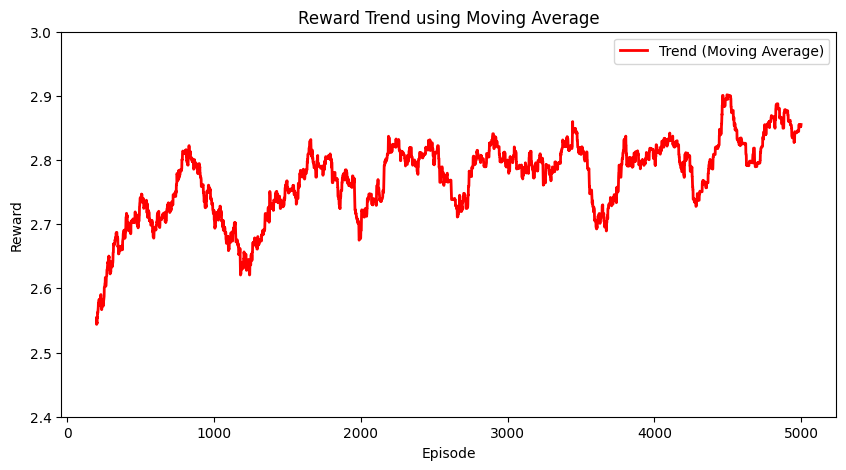

In [44]:
with open('SLURM/trainer_state.json') as jsonfile:
    trainerdata = json.load(jsonfile)

df_history = pd.DataFrame(trainerdata['log_history'])

smoothed_rewards = df_history['rewards/direct_lt_correctness_reward_func'].rolling(window=200).mean()

# Plotting the raw reward and the trend (smoothed reward)
plt.figure(figsize=(10, 5))
plt.plot(df_history.index, smoothed_rewards, label="Trend (Moving Average)", color="red", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.ylim(2.4,3)
plt.title("Reward Trend using Moving Average")
plt.legend()
plt.show()

We get a good improvement in accuracy after some RL, and we could probably have kept getting even better results by training longer.

## Neural transduction

In [56]:
from importlib import reload
import neural_utilities
reload(neural_utilities)
from neural_utilities import get_data

In [28]:
max_seq_length = 1024 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower

In [29]:
lt_system_prompt = ""

Let's start by defining some data that we'll use to train the model:

In [61]:
# get all sentences up to depth 5
sentences_pool = []
for i, sent in enumerate(enumerate_full_sentences('T', ltgrammar, max_depth=6)):
    sentences_pool.append(sent)
    if i==100000:
        break

In [69]:
data = get_data(
    ltgrammar, 
    lt_system_prompt, 
    eval_dict=lt_eval_dict, 
    n_tasks=100000, 
    sentences_pool=sentences_pool,
    n_inputs=4,
    n_transduction=2
)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Add the "completion" column to data which contains the string that the model is supposed to produce for the corresponding examples, containing a format that makes the model happy (we can later use the tokenizer to turn it into a properly formatted input for the model):

In [101]:
data = data.map(lambda x: {
    'completion': [{'content': ''.join(['\n-'+str(o) for _,o in x['answer_transduction']]), 'role': 'assistant'}], 
})

Map:   0%|          | 0/65536 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

In [ ]:
# 90% train, 10% test + validation
train_testvalid = data.train_test_split(train_size=2**16, test_size=2* 2**7)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
data = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [98]:
data

DatasetDict({
    train: Dataset({
        features: ['sentence', 'examples', 'task', 'answer_transduction', 'prompt', 'completion'],
        num_rows: 65536
    })
    test: Dataset({
        features: ['sentence', 'examples', 'task', 'answer_transduction', 'prompt', 'completion'],
        num_rows: 128
    })
    valid: Dataset({
        features: ['sentence', 'examples', 'task', 'answer_transduction', 'prompt', 'completion'],
        num_rows: 128
    })
})

Let's get the model:

In [75]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-0.5B-Instruct",
    max_seq_length=max_seq_length,
    # False for LoRA 16bit
    load_in_4bit=True, 
    # Enable vLLM fast inference
    fast_inference=True, 
    max_lora_rank=lora_rank,
    # Reduce if out of memory
    gpu_memory_utilization=0.5, 
)

# get the model with the lora adapters on top
model = FastLanguageModel.get_peft_model(
    model,
    # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    r=lora_rank, 
    # Which parts of the model are we gonna train?
    target_modules=[
        "q_proj", 
        "k_proj", 
        "v_proj", 
        "o_proj",
        "gate_proj", 
        "up_proj", 
        "down_proj",
    ], 
    lora_alpha=lora_rank,
    # Enable long context finetuning
    use_gradient_checkpointing = "unsloth", 
    random_state=3407,
)

==((====))==  Unsloth 2025.2.12: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU. Max memory: 4.0 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-0.5b-instruct-unsloth-bnb-4bit with actual GPU utilization = 40.19%
Unsloth: Your GPU has CUDA compute capability 8.6 with VRAM = 4.0 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 1024. Num Sequences = 128.
Unsloth: vLLM's KV Cache can use up to 1.08 GB. Also swap space = 1 GB.
INFO 03-14 16:51:40 config.py:542] This model supports multiple tasks: {'score', 'classify', 'reward', 'generate', 'embed'}. Defaulting to 'generate'.
Unsloth: vLLM Bitsandbytes con

[W314 16:51:42.352188826 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


INFO 03-14 16:51:42 loader.py:1102] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 03-14 16:51:43 weight_utils.py:252] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-14 16:51:44 model_runner.py:1115] Loading model weights took 0.5090 GB
INFO 03-14 16:51:44 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 03-14 16:51:48 worker.py:267] Memory profiling takes 2.86 seconds
INFO 03-14 16:51:48 worker.py:267] the current vLLM instance can use total_gpu_memory (4.00GiB) x gpu_memory_utilization (0.40) = 1.61GiB
INFO 03-14 16:51:48 worker.py:267] model weights take 0.51GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 0.70GiB; the rest of the memory reserved for KV Cache is 0.37GiB.
INFO 03-14 16:51:48 executor_base.py:110] # CUDA blocks: 2034, # CPU blocks: 5461
INFO 03-14 16:51:48 executor_base.py:115] Maximum concurrency for 1024 tokens per request: 31.78x
INFO 03-14 16:51:49 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occu

Capturing CUDA graph shapes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:18<00:00,  1.01it/s]

INFO 03-14 16:52:07 model_runner.py:1562] Graph capturing finished in 19 secs, took 0.30 GiB
INFO 03-14 16:52:07 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 23.04 seconds



Unsloth 2025.2.12 patched 24 layers with 24 QKV layers, 24 O layers and 24 MLP layers.


Now that we have a model we can apply the model's chat template to the datapoint we are using as a vibe check:

In [102]:
d = data['test'][1]

In [103]:
pprint(d)

{'answer_transduction': [[[2, 5], [2]], [[2, 1, 3], [2]]],
 'completion': [{'content': '\n-[2]\n-[2]', 'role': 'assistant'}],
 'examples': [[[4, 8, 3, 0, 0], [0, 0, 8, 4]],
              [[4, 5], [4]],
              [[2, 0, 8, 8, 2], [2, 8, 8, 0, 2]],
              [[4, 3, 7, 1, 1], [7, 4]]],
 'prompt': [{'content': '', 'role': 'system'},
            {'content': '-[4, 8, 3, 0, 0] -> [0, 0, 8, 4]\n'
                        '-[4, 5] -> [4]\n'
                        '-[2, 0, 8, 8, 2] -> [2, 8, 8, 0, 2]\n'
                        '-[4, 3, 7, 1, 1] -> [7, 4]\n'
                        '-[2, 5] -> ?\n'
                        '-[2, 1, 3] -> ?',
             'role': 'user'}],
 'sentence': 'compose(reverse,filter_(and_(or_(even,gt(5)),or_(gt(5),even))))',
 'task': '-[4, 8, 3, 0, 0] -> [0, 0, 8, 4]\n'
         '-[4, 5] -> [4]\n'
         '-[2, 0, 8, 8, 2] -> [2, 8, 8, 0, 2]\n'
         '-[4, 3, 7, 1, 1] -> [7, 4]\n'
         '-[2, 5] -> ?\n'
         '-[2, 1, 3] -> ?'}


In [ ]:
inputs = tokenizer.apply_chat_template(
    d,  
    # add generation from because we want to 
    # generate a response from the model
    add_generation_prompt=True,
    tokenize=True,
    return_tensors="pt",
    # return_dict=True,
).to('cuda')

Let's start by getting a sense of what the base model produced for our task:

In [81]:
FastLanguageModel.for_inference(model)
text_streamer = TextStreamer(tokenizer)
_ = model.generate(
    inputs, 
    streamer=text_streamer, 
    max_new_tokens=512,
)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<|im_start|>system
<|im_end|>
<|im_start|>user
-[4, 8, 3, 0, 0] -> [0, 0, 8, 4]
-[4, 5] -> [4]
-[2, 0, 8, 8, 2] -> [2, 8, 8, 0, 2]
-[4, 3, 7, 1, 1] -> [7, 4]
-[2, 5] -> ?
-[2, 1, 3] -> ?<|im_end|>
<|im_start|>assistant
It seems like you're working with a list of integers and you need to perform some operations on it. Let's go through each operation step by step.

### Operation 1: [4, 8, 3, 0, 0] -> [0, 0, 8, 4]
- The first operation is to convert the list to a list of integers.
- The list is [4, 8, 3, 0, 0].
- Converting it to a list of integers: `[4, 8, 3, 0, 0]`.

### Operation 2: [4, 5] -> [4]
- The second operation is to convert the list to a list of integers.
- The list is [4, 5].
- Converting it to a list of integers: `[4, 5]`.

### Operation 3: [2, 0, 8, 8, 2] -> [2, 8, 8, 0, 2]
- The third operation is to convert the list to a list of integers.
- The list is [2, 0, 8, 8, 2].
- Converting it to a list of integers: `[2, 0, 8, 8, 2]`.

### Operation 4: [4, 3, 7, 1, 1] -> [7, 4]
- 

This looks nothing like what we need, of course: we haven't even told the model what kind of answer we are expecting.

In [82]:
%%capture
FastLanguageModel.for_training(model)

So just like we did above, we can fine-tune the model to give the kind of response we want. 

Let's do supervised fine tuning on the model:

In [106]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        learning_rate=3e-5,
        lr_scheduler_type="linear",
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,
        # validation accuracy was going up again when training for too long!
        num_train_epochs=0.4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.05,
        warmup_steps=10,
        output_dir="lt_SFT_noreasoning",
        seed=0,
        save_steps=100,
        # feedback from evaluation set
        # from: https://github.com/unslothai/unsloth/wiki#evaluation-loop---also-oom-or-crashing
        fp16_full_eval=True,
        per_device_eval_batch_size=2,
        eval_accumulation_steps=4,
        eval_strategy="steps",
        eval_steps=10,
    ),
)

Map:   0%|          | 0/65536 [00:00<?, ? examples/s]

Converting train dataset to ChatML (num_proc=2):   0%|          | 0/65536 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/65536 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/65536 [00:00<?, ? examples/s]

Packing train dataset (num_proc=2):   0%|          | 0/65536 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Converting eval dataset to ChatML (num_proc=2):   0%|          | 0/128 [00:00<?, ? examples/s]

Applying chat template to eval dataset (num_proc=2):   0%|          | 0/128 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=2):   0%|          | 0/128 [00:00<?, ? examples/s]

Packing eval dataset (num_proc=2):   0%|          | 0/128 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


And let's train the model:

In [107]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 7,670 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 8 | Gradient Accumulation steps = 2
\        /    Total batch size = 16 | Total steps = 192
 "-____-"     Number of trainable parameters = 35,192,832


Step,Training Loss,Validation Loss
10,0.891400,1.672366
20,0.726400,1.525921
30,0.669800,1.422583
40,0.620600,1.368196
50,0.587300,1.344571
60,0.588500,1.332530
70,0.577800,1.321858
80,0.570500,1.308169
90,0.561800,1.308967
100,0.566000,1.302481


Unsloth: Not an error, but Qwen2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


TrainOutput(global_step=192, training_loss=0.612208171437184, metrics={'train_runtime': 1680.2969, 'train_samples_per_second': 1.826, 'train_steps_per_second': 0.114, 'total_flos': 4553328637771776.0, 'train_loss': 0.612208171437184})

At this point we have the model and the adapter which contains the lora weights.

In [108]:
trainer.save_model('finetuned_lt_transduction')

Now we can just get the saved model: 

In [16]:
%%capture
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "finetuned_lt_transduction",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    # Enable vLLM fast inference
    fast_inference = True, 
)

INFO 03-13 17:33:48 config.py:542] This model supports multiple tasks: {'embed', 'classify', 'reward', 'score', 'generate'}. Defaulting to 'generate'.
INFO 03-13 17:33:49 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='unsloth/qwen2.5-0.5b-instruct-unsloth-bnb-4bit', speculative_config=None, tokenizer='unsloth/qwen2.5-0.5b-instruct-unsloth-bnb-4bit', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=1024, download_dir=None, load_format=LoadFormat.BITSANDBYTES, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=bitsandbytes, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda:0, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), 

[W313 17:33:50.736917400 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


INFO 03-13 17:33:50 loader.py:1102] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 03-13 17:33:51 weight_utils.py:252] Using model weights format ['*.safetensors']
INFO 03-13 17:33:53 model_runner.py:1115] Loading model weights took 0.5090 GB
INFO 03-13 17:33:53 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 03-13 17:33:56 worker.py:267] Memory profiling takes 2.87 seconds
INFO 03-13 17:33:56 worker.py:267] the current vLLM instance can use total_gpu_memory (4.00GiB) x gpu_memory_utilization (0.40) = 1.61GiB
INFO 03-13 17:33:56 worker.py:267] model weights take 0.51GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 0.70GiB; the rest of the memory reserved for KV Cache is 0.37GiB.
INFO 03-13 17:33:56 executor_base.py:110] # CUDA blocks: 2034, # CPU blocks: 5461
INFO 03-13 17:33:56 executor_base.py:115] Maximum concurrency for 1024 tokens per request: 31.78x
INFO 03-13 17:33:57 model_runner.py:1434] Capturing cudagraphs for decoding

Unsloth 2025.2.12 patched 24 layers with 24 QKV layers, 24 O layers and 24 MLP layers.


In [109]:
# strangely, this is not a default
tokenizer.padding_side = 'left'

In [110]:
inputs = tokenizer.apply_chat_template(
    data['test']['prompt'],  
    # add generation prompt because we want to 
    # generate a response from the model
    add_generation_prompt=True,
    tokenize=True,
    # return_tensors="pt",
    padding=True,
    return_dict=True,
)

An example of the kind of input we are passing to the model:

In [111]:
print(tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True))

system

user
-[1, 9, 0, 8, 8] -> [9, 8, 8]
-[5, 0] -> [5]
-[2, 4, 1, 2] -> [4]
-[2, 5] -> [5]
-[3, 1, 6] -> ?
-[0, 6] -> ?
assistant



In [112]:
%%capture
FastLanguageModel.for_inference(model)

Let's make the model trasduct on the test data and see how often it gets it right!

In [113]:
answer = []
for inp in inputs['input_ids']:
    text_upto_padding = inp[inp.index(151644)+1:]
    sft_test_generation = model.generate(
        tensor([text_upto_padding], dtype=torch.int64).to('cuda'),
        # attention_mask=inputs['attention_mask'][10][None],
        pad_token_id=tokenizer.pad_token_id,
        max_new_tokens=128,
    )
    answer.append(tokenizer.decode(sft_test_generation[0][len(text_upto_padding):],skip_special_tokens=True))

The accuracy in a task is the average number of correct predictions across incomplete example:

In [141]:
def check_accuracy(x, indices, answer):
    accuracy = []
    for a,b in zip(x['completion'][0]['content'].strip().split('\n'), answer[indices].split('\n')):
        if a == b:
            accuracy.append(1)
        else:
            accuracy.append(0)
    return {'accuracy': np.mean(accuracy)}

And let's see how accurate these answers were:

In [142]:
data['test'] = data['test'].map(check_accuracy, fn_kwargs={'answer':answer},with_indices=True)

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Really not bad! More than half of the predictions are correct:

Not bad! In 0.77 of cases the model got at least one answer correct:

In [153]:
np.unique(data['test']['accuracy'], return_counts=True)

(array([0. , 0.5, 1. ]), array([29, 54, 45]))

That's a big improvement compared to the initial answers!